# Giga Recurrent Unbounded Network ➿

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler
import wandb
from IPython.display import Markdown

### DataLoader

_(Non serve più)_

In [2]:
class CustomDataset(Dataset):
    TARGET_MASK_ID = 1
    FEATURES_MASK_ID = 0
    DAY_IN_MINUTES = 287
    __DAYS_IN_MONTH = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    EXCLUDE_FEATURES = [
        "Failure", "Frequency", "Status", "Others",
        "Code", "name", "deviceid", "serial",
        "SB0", "Phase", "NV10P", "TotalEnergy_QuotControl", "TotalEnergyImported"
        #"INV01_TotalEnergy", "INV02_TotalEnergy", "INV03_TotalEnergy",
        #"cos",
        #"sin",
        "state", "SOL", "NA16", 
        #'soil_moisture_7_to_28cm (m³/m³)',
    ]
    SCALER = None
    df = None
    
    def __init__(self, dataset_path="merged_annuale_meteo.csv", window=1, target_size=1, eval=False, verbose=False):
        CustomDataset.__init_df(dataset_path)
        #self.df = pd.read_csv(dataset_path, delimiter = ";")
        #self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], yearfirst=True)
        #cols_to_remove = [column  for column in self.df.columns if len([elem for elem in self.EXCLUDE_FEATURES if elem in column]) > 0]
        #self.df = self.df.drop(columns=cols_to_remove)
        
        # filtro per le date contenute nel range start_date < x < end_date
        #self.df = self.df[self.df['timestamp'] > pd.to_datetime(start_date)]
        #self.df = self.df[self.df['timestamp'] < pd.to_datetime(end_date)]
        
        # aggiunta encoding ciclico minuti, giorni
        #self.__ciclic_time_encoder()
        
        # trasformo la target series in Non Cumulativa
        #self.df['target'] = self.df['Cont_TotalEnergy(kWh)'].diff().fillna(0)
        
        # inizializzo lo scaler ed effettuo la normalizzazione dei dati
        #self.scaler = MinMaxScaler().fit(self.df.drop(columns=['timestamp'])) # ignoro la colonna del timestamp
        #self.df.loc[:, self.df.columns != 'timestamp'] = self.scaler.transform(self.df.loc[:, self.df.columns != 'timestamp'])
        
        self.window = window
        self.target_size = target_size # numero di giorni da interpolare
        self.shape = self.df.shape
        self.verbose = verbose
        self.eval = eval
        
        # if self.verbose:
            # controllo se le colonne hanno dei NaN
        #    print("Padre:", self.df.isna().any())
            
    def __ciclic_time_encoder(self, col_name='timestamp'):
        tmp_datetime_serie = pd.to_datetime(arg=self.df[col_name], yearfirst=True)
        
        #month = tmp_datetime_serie.dt.month - 1
        #day = tmp_datetime_serie.dt.day - 1
        #display(day)
        
        self.df["minute_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)
        self.df["minute_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)
        
        # ci può piacere così ??
        self.df["day_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)
        self.df["day_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)
        
        # va fatto con il -1 ???
        #self.df["month_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.month/12.0)
        #self.df["month_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.month/12.0)

        #df["hour_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.hour/24.0)
        #df["hour_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.hour/24.0)

    def __len__(self):
        temp= (self.df.shape[0]/self.DAY_IN_MINUTES)-(2*(self.window) + (self.target_size))-1
        #print("TEMP:", temp)
        #print("DF ROWS:", self.df.shape[0])
        #print("PRE DIFF", (2*(self.window*self.DAY_IN_MINUTES) + (self.target_size*self.DAY_IN_MINUTES)))
        #print((2*(self.window*self.DAY_IN_MINUTES) + (self.target_size*self.DAY_IN_MINUTES)))
        return int(temp)
        #return len(self.df)
    
    def __getitem__(self, idx):
        days = self.df.iloc[0+(idx*self.DAY_IN_MINUTES): self.DAY_IN_MINUTES*(self.window+self.target_size+self.window)+(idx*self.DAY_IN_MINUTES), ~self.df.columns.str.contains('^Unnamed')]
        days = days.drop(columns=['Cont_TotalEnergy(kWh)']) # rimuovo la T.S. cumulativa
        
        # timestamp = days['timestamp']
        
        if self.verbose:
            display("Target from dataframe")
            display(days)
                
        days = days[days.columns.drop(list(days.filter(regex='^.*_name.*$')))]
        days = days[days.columns.drop(list(days.filter(regex='^Unnamed')))]
        days['timestamp'] = pd.to_numeric(days['timestamp']) # si potrebbe rimuovere
        
        if self.verbose:
            display("Target after processing")
            display(days)
        
        target = days[self.DAY_IN_MINUTES*self.window:self.DAY_IN_MINUTES*(self.window+self.target_size)]
        
        # 'FUTURE' FEATURES
        decoder_input = target.copy()
        decoder_input = decoder_input[[
            'Impianto_SolargisGHI(W/m2)','Impianto_SolargisGTI(W/m2)', 
            'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_sin', 'day_cos',
            'temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)', 
            'rain (mm)', 'cloudcover (%)', 'soil_temperature_7_to_28cm (°C)', 'soil_moisture_7_to_28cm (m³/m³)'
        ]]
        
        timestamp = target['timestamp']
        target = target['target']
                
        # target = target['Cont_TotalEnergy(kWh)']
        
        data_left = days[0:self.DAY_IN_MINUTES*self.window]
        data_right = days[self.DAY_IN_MINUTES*(self.window+self.target_size):]
        #data = pd.concat([data_left, data_right])
        
        tensor_type = torch.float64 # forza il tipo in double (serve per il testing timestamp)
        
        # la rimozione del timestamp viene fatta solo se verbose==False,
        # sta ad indicare che non siamo più nella fase di tesing
        if self.verbose == False:
            # rimuovo il tiemestamp dato che la ciclicità è stata modellata con sin e cos
            #    N.B.: target non ha timestamp, ma solo i valori della corrente !
            data_left = data_left.drop(columns=['timestamp'])
            data_right = data_right.drop(columns=['timestamp'])

            tensor_type = torch.float32 # forza il tipo in float (si potrebbe anche scendere)

        # mask = [self.FEATURES_MASK_ID]*(self.window*self.DAY_IN_MINUTES) + [self.TARGET_MASK_ID]*(self.target_size*self.DAY_IN_MINUTES) + [self.FEATURES_MASK_ID]*(self.window*self.DAY_IN_MINUTES)
        
        #if self.verbose:
        #    display("Mask")
        #    display(mask)
        #    display(decoder_input)
        
        tensor_target = torch.tensor(target.values, dtype=tensor_type)
        tensor_target = torch.reshape(tensor_target, (self.target_size*self.DAY_IN_MINUTES, 1))
        tensor_before = torch.tensor(data_left.values, dtype=tensor_type)
        tensor_after  = torch.tensor(data_right.values, dtype=tensor_type)
        tesnor_future = torch.tensor(decoder_input.values, dtype=tensor_type)
        #prediction_len = torch.tensor([tensor_target.shape[0]], dtype=tensor_type)
        #prediction_len = prediction_len.unsqueeze(0)

        # per gru iniziali non serve (?)
        #tensor_before = tensor_before[None, :]
        #tensor_after  = tensor_after[None, :]

        to_return = (tensor_target, tensor_before, tensor_after, tesnor_future,)
        
        if self.eval:
            to_return += (timestamp,)

        return to_return
    
    def __scale_dataset(self):
                self.df.loc[:, self.df.columns != 'timestamp'] = self.SCALER.transform(
                    self.df.loc[:, self.df.columns != 'timestamp']
                )
        
    def set_verbose(self, value: bool):
        self.verbose = value
    
    def summary(self):
        print("Are NaN inside ??")
        print(self.df.isna().any())
        display(self.df['timestamp'])
    
    @classmethod
    def set_scaler(cls, scaler: MinMaxScaler):
        cls.SCALER = scaler
    
    @classmethod
    def __init_df(cls, path: str):
        if cls.df is None:
            cls.df = pd.read_csv(path, delimiter = ";")
            cls.df['timestamp'] = pd.to_datetime(cls.df['timestamp'], yearfirst=True)
            cols_to_remove = [column  for column in cls.df.columns if len([elem for elem in cls.EXCLUDE_FEATURES if elem in column]) > 0]
            cls.df = cls.df.drop(columns=cols_to_remove)

            # aggiunta encoding ciclico minuti, giorni
            tmp_datetime_serie = pd.to_datetime(arg=cls.df['timestamp'], yearfirst=True)
        
            cls.df["minute_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)
            cls.df["minute_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)

            cls.df["day_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)
            cls.df["day_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)

            # trasformo la target series in Non Cumulativa
            cls.df['target'] = cls.df['Cont_TotalEnergy(kWh)'].diff().fillna(0)
        

In [3]:
class TrainingDataset(CustomDataset):
    
    def __init__(self, window=1, target_size=1, start_date='2022-06-01', end_date='2023-01-01', scaler:MinMaxScaler=None, verbose=False):
        super().__init__(window=window, target_size=target_size, verbose=verbose)
        
        # filtro per le date contenute nel range start_date < x < end_date
        self.df = self.df[self.df['timestamp'] > pd.to_datetime(start_date)]
        self.df = self.df[self.df['timestamp'] < pd.to_datetime(end_date)]
        
        CustomDataset.set_scaler(scaler.fit(self.df.drop(columns=['timestamp']))) # ignoro la colonna del timestamp
        
        self.df.loc[:, self.df.columns != 'timestamp'] = self.SCALER.transform(
                    self.df.loc[:, self.df.columns != 'timestamp']
                )

        if self.verbose:
            self.summary()
            
    #def __len__(self):
    #    return 2 # TODO: SISTEMARE !!

In [4]:
class ValidationDataset(CustomDataset):
    
    def __init__(self, window=1, target_size=1, start_date='2023-01-01', end_date='2023-02-01', verbose=False):
        super().__init__(window=window, target_size=target_size, verbose=verbose)
        # filtro per le date contenute nel range start_date < x < end_date
        self.df = self.df[self.df['timestamp'] > pd.to_datetime(start_date)]
        self.df = self.df[self.df['timestamp'] < pd.to_datetime(end_date)]
        
        self.df.loc[:, self.df.columns != 'timestamp'] = self.SCALER.transform(
                    self.df.loc[:, self.df.columns != 'timestamp']
                )
        
        if self.verbose:
            self.summary()

    def __len__(self):
        return 25 # TODO: SISTEMARE !!

In [5]:
class TestingDataset(CustomDataset):
    
    def __init__(self, window=1, target_size=1, start_date='2023-02-01', end_date='2023-03-01', verbose=False):
        super().__init__(window=window, target_size=target_size, verbose=verbose)
        # filtro per le date contenute nel range start_date < x < end_date
        self.df = self.df[self.df['timestamp'] > pd.to_datetime(start_date)]
        self.df = self.df[self.df['timestamp'] < pd.to_datetime(end_date)]
        
        self.df.loc[:, self.df.columns != 'timestamp'] = self.SCALER.transform(
                    self.df.loc[:, self.df.columns != 'timestamp']
                )

        if self.verbose:
            self.summary()

In [6]:
def generate_datasets(verbose=False):
    train_scaler = MinMaxScaler()

    train_dataset = TrainingDataset(
        window=run.config['window_size'], target_size=run.config['target_size'], 
        scaler = train_scaler,
        verbose=verbose
        
    )
    validation_dataset = ValidationDataset(
        window=run.config['window_size'], target_size=run.config['target_size'], 
        verbose=verbose
    )
    testing_dataset = TestingDataset(
        window=run.config['window_size'], target_size=run.config['target_size'], 
        verbose=verbose
    )
    
    return train_dataset, validation_dataset, testing_dataset

## Dataloader Meglio

### Dataset Preprocessing

In [2]:
DAY_IN_MINUTES = 287

EXCLUDE_FEATURES = [
    "Failure", "Frequency", "Status", "Others",
    "Code", "name", "deviceid", "serial",
    "SB0", "Phase", "NV10P", "TotalEnergy_QuotControl", "TotalEnergyImported"
    #"INV01_TotalEnergy", "INV02_TotalEnergy", "INV03_TotalEnergy",
    #"cos",
    #"sin",
    "state", "SOL", "NA16", 
    #'soil_moisture_7_to_28cm (m³/m³)',
]
PATH = "merged_annuale_meteo.csv"

In [3]:
df = pd.read_csv(PATH, delimiter = ";")
df['timestamp'] = pd.to_datetime(df['timestamp'], yearfirst=True)
cols_to_remove = [column  for column in df.columns if len([elem for elem in EXCLUDE_FEATURES if elem in column]) > 0]
df = df.drop(columns=cols_to_remove)

# aggiunta encoding ciclico minuti, giorni
tmp_datetime_serie = pd.to_datetime(arg=df['timestamp'], yearfirst=True)

df["minute_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)
df["minute_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)

df["day_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)
df["day_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)

# trasformo la target series in Non Cumulativa
df['target'] = df['Cont_TotalEnergy(kWh)'].diff().fillna(0)

In [4]:
df = df.set_index(df['timestamp'])

In [5]:
train_df = df[df['timestamp'] > pd.to_datetime('2022-06-01')]
train_df = train_df[df['timestamp'] < pd.to_datetime('2023-01-01')]

val_df = df[df['timestamp'] > pd.to_datetime('2023-01-01')]
val_df = val_df[df['timestamp'] < pd.to_datetime('2023-02-01')]

test_df = df[df['timestamp'] > pd.to_datetime('2023-02-01')]
test_df = test_df[df['timestamp'] < pd.to_datetime('2023-03-01')]

/tmp/ipykernel_258/2891437234.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[df['timestamp'] < pd.to_datetime('2023-01-01')]
/tmp/ipykernel_258/2891437234.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = val_df[df['timestamp'] < pd.to_datetime('2023-02-01')]
/tmp/ipykernel_258/2891437234.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = test_df[df['timestamp'] < pd.to_datetime('2023-03-01')]


In [6]:
display(Markdown("### Training Dataframe"))
display(train_df)

display(Markdown("### Validation Dataframe"))
display(val_df)

display(Markdown("### Testing Dataframe"))
display(test_df)

### Training Dataframe

timestamp  INV01_CurrentDC(A)  \
timestamp                                                     
2022-06-01 00:05:00 2022-06-01 00:05:00                 0.0   
2022-06-01 00:10:00 2022-06-01 00:10:00                 0.0   
2022-06-01 00:15:00 2022-06-01 00:15:00                 0.0   
2022-06-01 00:20:00 2022-06-01 00:20:00                 0.0   
2022-06-01 00:25:00 2022-06-01 00:25:00                 0.0   
...                                 ...                 ...   
2022-12-31 23:35:00 2022-12-31 23:35:00                 0.0   
2022-12-31 23:40:00 2022-12-31 23:40:00                 0.0   
2022-12-31 23:45:00 2022-12-31 23:45:00                 0.0   
2022-12-31 23:50:00 2022-12-31 23:50:00                 0.0   
2022-12-31 23:55:00 2022-12-31 23:55:00                 0.0   

                     INV01_CurrentAC(A)  INV01_TotalEnergy(kWh)  \
timestamp                                                         
2022-06-01 00:05:00                 0.0               145517.08   
2022-06-01 00:10:00                 0.0               145517.08   
2022-06-01 00:15:00                 0.0               145517.08   
2022-06-01 00:20:00                 0.0               145517.08   
2022-06-01 00:25:00                 0.0               145517.08   
...                                 ...                     ...   
2022-12-31 23:35:00                 0.0               410725.44   
2022-12-31 23:40:00                 0.0               410725.44   
2022-12-31 23:45:00                 0.0               410725.44   
2022-12-31 23:50:00                 0.0               410725.44   
2022-12-31 23:55:00                 0.0               410725.44   

                     INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
timestamp                                                   
2022-06-01 00:05:00                0.0                0.0   
2022-06-01 00:10:00                0.0                0.0   
2022-06-01 00:15:00                0.0                0.0   
2022-06-01 00:20:00                0.0                0.0   
2022-06-01 00:25:00                0.0                0.0   
...                                ...                ...   
2022-12-31 23:35:00                0.0                0.0   
2022-12-31 23:40:00                0.0                0.0   
2022-12-31 23:45:00                0.0                0.0   
2022-12-31 23:50:00                0.0                0.0   
2022-12-31 23:55:00                0.0                0.0   

                     INV01_InternalTemperature(C)  \
timestamp                                           
2022-06-01 00:05:00                           0.0   
2022-06-01 00:10:00                           0.0   
2022-06-01 00:15:00                           0.0   
2022-06-01 00:20:00                           0.0   
2022-06-01 00:25:00                           0.0   
...                                           ...   
2022-12-31 23:35:00                           0.0   
2022-12-31 23:40:00                           0.0   
2022-12-31 23:45:00                           0.0   
2022-12-31 23:50:00                           0.0   
2022-12-31 23:55:00                           0.0   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2022-06-01 00:05:00                           0.0                 0.0   
2022-06-01 00:10:00                           0.0                 0.0   
2022-06-01 00:15:00                           0.0                 0.0   
2022-06-01 00:20:00                           0.0                 0.0   
2022-06-01 00:25:00                           0.0                 0.0   
...                                           ...                 ...   
2022-12-31 23:35:00                           0.0                 0.0   
2022-12-31 23:40:00                           0.0                 0.0   
2022-12-31 23:45:00                           0.0                 0.0   
2022-12-31 23:50:00                           0.0  

### Validation Dataframe

timestamp  INV01_CurrentDC(A)  \
timestamp                                                     
2023-01-01 00:05:00 2023-01-01 00:05:00                 0.0   
2023-01-01 00:10:00 2023-01-01 00:10:00                 0.0   
2023-01-01 00:15:00 2023-01-01 00:15:00                 0.0   
2023-01-01 00:20:00 2023-01-01 00:20:00                 0.0   
2023-01-01 00:25:00 2023-01-01 00:25:00                 0.0   
...                                 ...                 ...   
2023-01-31 23:35:00 2023-01-31 23:35:00                 0.0   
2023-01-31 23:40:00 2023-01-31 23:40:00                 0.0   
2023-01-31 23:45:00 2023-01-31 23:45:00                 0.0   
2023-01-31 23:50:00 2023-01-31 23:50:00                 0.0   
2023-01-31 23:55:00 2023-01-31 23:55:00                 0.0   

                     INV01_CurrentAC(A)  INV01_TotalEnergy(kWh)  \
timestamp                                                         
2023-01-01 00:05:00                 0.0               410725.44   
2023-01-01 00:10:00                 0.0               410725.44   
2023-01-01 00:15:00                 0.0               410725.44   
2023-01-01 00:20:00                 0.0               410725.44   
2023-01-01 00:25:00                 0.0               410725.44   
...                                 ...                     ...   
2023-01-31 23:35:00                 0.0               431324.36   
2023-01-31 23:40:00                 0.0               431324.36   
2023-01-31 23:45:00                 0.0               431324.36   
2023-01-31 23:50:00                 0.0               431324.36   
2023-01-31 23:55:00                 0.0               431324.36   

                     INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
timestamp                                                   
2023-01-01 00:05:00                0.0                0.0   
2023-01-01 00:10:00                0.0                0.0   
2023-01-01 00:15:00                0.0                0.0   
2023-01-01 00:20:00                0.0                0.0   
2023-01-01 00:25:00                0.0                0.0   
...                                ...                ...   
2023-01-31 23:35:00                0.0                0.0   
2023-01-31 23:40:00                0.0                0.0   
2023-01-31 23:45:00                0.0                0.0   
2023-01-31 23:50:00                0.0                0.0   
2023-01-31 23:55:00                0.0                0.0   

                     INV01_InternalTemperature(C)  \
timestamp                                           
2023-01-01 00:05:00                           0.0   
2023-01-01 00:10:00                           0.0   
2023-01-01 00:15:00                           0.0   
2023-01-01 00:20:00                           0.0   
2023-01-01 00:25:00                           0.0   
...                                           ...   
2023-01-31 23:35:00                           0.0   
2023-01-31 23:40:00                           0.0   
2023-01-31 23:45:00                           0.0   
2023-01-31 23:50:00                           0.0   
2023-01-31 23:55:00                           0.0   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2023-01-01 00:05:00                           0.0                 0.0   
2023-01-01 00:10:00                           0.0                 0.0   
2023-01-01 00:15:00                           0.0                 0.0   
2023-01-01 00:20:00                           0.0                 0.0   
2023-01-01 00:25:00                           0.0                 0.0   
...                                           ...                 ...   
2023-01-31 23:35:00                           0.0                 0.0   
2023-01-31 23:40:00                           0.0                 0.0   
2023-01-31 23:45:00                           0.0                 0.0   
2023-01-31 23:50:00                           0.0  

### Testing Dataframe

timestamp  INV01_CurrentDC(A)  \
timestamp                                                     
2023-02-01 00:05:00 2023-02-01 00:05:00                0.00   
2023-02-01 00:10:00 2023-02-01 00:10:00                0.00   
2023-02-01 00:15:00 2023-02-01 00:15:00                0.00   
2023-02-01 00:20:00 2023-02-01 00:20:00                0.00   
2023-02-01 00:25:00 2023-02-01 00:25:00                0.00   
...                                 ...                 ...   
2023-02-28 23:35:00 2023-02-28 23:35:00              179.75   
2023-02-28 23:40:00 2023-02-28 23:40:00              179.75   
2023-02-28 23:45:00 2023-02-28 23:45:00              179.75   
2023-02-28 23:50:00 2023-02-28 23:50:00              179.75   
2023-02-28 23:55:00 2023-02-28 23:55:00              179.75   

                     INV01_CurrentAC(A)  INV01_TotalEnergy(kWh)  \
timestamp                                                         
2023-02-01 00:05:00                 0.0               431324.36   
2023-02-01 00:10:00                 0.0               431324.36   
2023-02-01 00:15:00                 0.0               431324.36   
2023-02-01 00:20:00                 0.0               431324.36   
2023-02-01 00:25:00                 0.0               431324.36   
...                                 ...                     ...   
2023-02-28 23:35:00               232.3               461346.36   
2023-02-28 23:40:00               232.3               461346.36   
2023-02-28 23:45:00               232.3               461346.36   
2023-02-28 23:50:00               232.3               461346.36   
2023-02-28 23:55:00               232.3               461346.36   

                     INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
timestamp                                                   
2023-02-01 00:05:00                0.0                0.0   
2023-02-01 00:10:00                0.0                0.0   
2023-02-01 00:15:00                0.0                0.0   
2023-02-01 00:20:00                0.0                0.0   
2023-02-01 00:25:00                0.0                0.0   
...                                ...                ...   
2023-02-28 23:35:00              104.7              112.1   
2023-02-28 23:40:00              104.7              112.1   
2023-02-28 23:45:00              104.7              112.1   
2023-02-28 23:50:00              104.7              112.1   
2023-02-28 23:55:00              104.7              112.1   

                     INV01_InternalTemperature(C)  \
timestamp                                           
2023-02-01 00:05:00                          0.00   
2023-02-01 00:10:00                          0.00   
2023-02-01 00:15:00                          0.00   
2023-02-01 00:20:00                          0.00   
2023-02-01 00:25:00                          0.00   
...                                           ...   
2023-02-28 23:35:00                         21.19   
2023-02-28 23:40:00                         21.19   
2023-02-28 23:45:00                         21.19   
2023-02-28 23:50:00                         21.19   
2023-02-28 23:55:00                         21.19   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2023-02-01 00:05:00                          0.00                 0.0   
2023-02-01 00:10:00                          0.00                 0.0   
2023-02-01 00:15:00                          0.00                 0.0   
2023-02-01 00:20:00                          0.00                 0.0   
2023-02-01 00:25:00                          0.00                 0.0   
...                                           ...                 ...   
2023-02-28 23:35:00                         58.78               624.1   
2023-02-28 23:40:00                         58.78               624.1   
2023-02-28 23:45:00                         58.78               624.1   
2023-02-28 23:50:00                         58.78  

### Dataset & DataLoader

In [7]:
BATCH_SIZE = 10

In [8]:
class CustomDataset(Dataset):
    MAX_DAYS = 4
    MIN_DAYS = 1

    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        self.counter = 0
        self.target_len = -1
    
    def __len__(self):
        return int(len(self.df)/287)-2 - self.MAX_DAYS
    
    def __getitem__(self, idx):
        #before_len = np.random.randint(1, self.MAX_DAYS+1)
        #after_len = np.random.randint(1, self.MAX_DAYS+1)
        if self.counter == self.batch_size:
            self.counter = 0
        
        if self.counter == 0:
            self.target_len = np.random.randint(1, self.MAX_DAYS+1)
        
        tmp_df = self.df.iloc[0+(287*(idx+1)) - 287 : (287*(idx+1))+(287*self.target_len) + 287]
        timestamps = tmp_df['timestamp']
        tmp_df = tmp_df.drop(columns=['timestamp'])

        mask_before = np.array([1]*287 + [0]*(len(tmp_df) - 287))
        mask_after = np.array([0] * (len(tmp_df) - 287) + [1]*287)
        mask_target = np.array([0]*287 + [1] * (len(tmp_df) - 287*2) +[0] * 287)
        
        # print(len(mask_target), f"{timestamps[0]}-{timestamps[-1]}")
        
        before = tmp_df[mask_before == 1]
        target = tmp_df[mask_target == 1]
        after  = tmp_df[mask_after == 1]
        
        future = target.copy()
        future = future[[
            'Impianto_SolargisGHI(W/m2)','Impianto_SolargisGTI(W/m2)', 
            'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_sin', 'day_cos',
            'temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)', 
            'rain (mm)', 'cloudcover (%)', 'soil_temperature_7_to_28cm (°C)', 'soil_moisture_7_to_28cm (m³/m³)'
        ]]
        
        target = target['target']
        
        self.counter += 1
        
        #print(mask_before)
        #print(mask_target)
        #print(mask_after)
        
        return before, target, future, after, mask_before, mask_target, mask_after, timestamps
    
    def reset(self):
        self.counter = 0

In [9]:
def collate_fn(batch):
    # ha senso usare del padding ??
    before, target, future, after, masks_before, masks_target, masks_after, timestamps = zip(*batch)
    
    before = [torch.tensor(d.values, dtype=torch.float32) for d in before]
    before = torch.stack(before)
    
    target = [torch.tensor(d.values, dtype=torch.float32) for d in target]
    target = [torch.reshape(d, (d.shape[0], 1)) for d in target] # voglio shape [len_buco, 1]
    target = torch.stack(target)
    
    future = [torch.tensor(d.values, dtype=torch.float32) for d in future]
    future = torch.stack(future)
    
    after = [torch.tensor(d.values, dtype=torch.float32) for d in after]
    after = torch.stack(after)
    
    return before, target, future, after, masks_before, masks_target, masks_after, timestamps

### Tests

In [9]:
train_dataset = CustomDataset(train_df, BATCH_SIZE)

In [10]:
len(train_dataset)

208

In [12]:
b, t, f, a, mask_b, mask_t, mask_a, timestamps = train_dataset[0]

print(len(mask_b), len(mask_t), len(mask_a))

display(Markdown("### Before"))
display(b)
display(Markdown("### Target"))
display(t)
display(Markdown("### Future"))
display(f)
display(Markdown("### After"))
display(a)
display(Markdown("### Timestamps"))
display(timestamps)


1148 2022-06-01 00:05:00-2022-06-04 23:55:00
1148 1148 1148


### Before

INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
timestamp                                                     
2022-06-01 00:05:00                 0.0                 0.0   
2022-06-01 00:10:00                 0.0                 0.0   
2022-06-01 00:15:00                 0.0                 0.0   
2022-06-01 00:20:00                 0.0                 0.0   
2022-06-01 00:25:00                 0.0                 0.0   
...                                 ...                 ...   
2022-06-01 23:35:00                 0.0                 0.0   
2022-06-01 23:40:00                 0.0                 0.0   
2022-06-01 23:45:00                 0.0                 0.0   
2022-06-01 23:50:00                 0.0                 0.0   
2022-06-01 23:55:00                 0.0                 0.0   

                     INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  \
timestamp                                                        
2022-06-01 00:05:00               145517.08                0.0   
2022-06-01 00:10:00               145517.08                0.0   
2022-06-01 00:15:00               145517.08                0.0   
2022-06-01 00:20:00               145517.08                0.0   
2022-06-01 00:25:00               145517.08                0.0   
...                                     ...                ...   
2022-06-01 23:35:00               147319.68                0.0   
2022-06-01 23:40:00               147319.68                0.0   
2022-06-01 23:45:00               147319.68                0.0   
2022-06-01 23:50:00               147319.68                0.0   
2022-06-01 23:55:00               147319.68                0.0   

                     INV01_PowerDC(kW)  INV01_InternalTemperature(C)  \
timestamp                                                              
2022-06-01 00:05:00                0.0                           0.0   
2022-06-01 00:10:00                0.0                           0.0   
2022-06-01 00:15:00                0.0                           0.0   
2022-06-01 00:20:00                0.0                           0.0   
2022-06-01 00:25:00                0.0                           0.0   
...                                ...                           ...   
2022-06-01 23:35:00                0.0                           0.0   
2022-06-01 23:40:00                0.0                           0.0   
2022-06-01 23:45:00                0.0                           0.0   
2022-06-01 23:50:00                0.0                           0.0   
2022-06-01 23:55:00                0.0                           0.0   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2022-06-01 00:05:00                           0.0                 0.0   
2022-06-01 00:10:00                           0.0                 0.0   
2022-06-01 00:15:00                           0.0                 0.0   
2022-06-01 00:20:00                           0.0                 0.0   
2022-06-01 00:25:00                           0.0                 0.0   
...                                           ...                 ...   
2022-06-01 23:35:00                           0.0                 0.0   
2022-06-01 23:40:00                           0.0                 0.0   
2022-06-01 23:45:00                           0.0                 0.0   
2022-06-01 23:50:00                           0.0                 0.0   
2022-06-01 23:55:00                           0.0                 0.0   

                     INV01_VoltageAC(V)  INV02_CurrentDC(A)  ...  \
timestamp                                                    ...   
2022-06-01 00:05:00                 0.0                 0.0  ...   
2022-06-01 00:10:00                 0.0                 0.0  ...   
2022-06-01 00:15:00                 0.0                 0.0  ...   
2022-06-01 00:20:00                 0.0                 0.0  ...   
2022-06-01 00:25:00                 0.0        

### Target

timestamp
2022-06-02 00:05:00    0.0
2022-06-02 00:10:00    0.0
2022-06-02 00:15:00    0.0
2022-06-02 00:20:00    0.0
2022-06-02 00:25:00    0.0
                      ... 
2022-06-03 23:35:00    0.0
2022-06-03 23:40:00    0.0
2022-06-03 23:45:00    0.0
2022-06-03 23:50:00    0.0
2022-06-03 23:55:00    0.0
Name: target, Length: 574, dtype: float64

### Future

Impianto_SolargisGHI(W/m2)  Impianto_SolargisGTI(W/m2)  \
timestamp                                                                     
2022-06-02 00:05:00                         0.0                         0.0   
2022-06-02 00:10:00                         0.0                         0.0   
2022-06-02 00:15:00                         0.0                         0.0   
2022-06-02 00:20:00                         0.0                         0.0   
2022-06-02 00:25:00                         0.0                         0.0   
...                                         ...                         ...   
2022-06-03 23:35:00                         0.0                         0.0   
2022-06-03 23:40:00                         0.0                         0.0   
2022-06-03 23:45:00                         0.0                         0.0   
2022-06-03 23:50:00                         0.0                         0.0   
2022-06-03 23:55:00                         0.0                         0.0   

                        month_sin  month_cos  hour_sin  hour_cos  minute_sin  \
timestamp                                                                      
2022-06-02 00:05:00  1.224647e-16       -1.0  0.000000  1.000000    0.500000   
2022-06-02 00:10:00  1.224647e-16       -1.0  0.000000  1.000000    0.866025   
2022-06-02 00:15:00  1.224647e-16       -1.0  0.000000  1.000000    1.000000   
2022-06-02 00:20:00  1.224647e-16       -1.0  0.000000  1.000000    0.866025   
2022-06-02 00:25:00  1.224647e-16       -1.0  0.000000  1.000000    0.500000   
...                           ...        ...       ...       ...         ...   
2022-06-03 23:35:00  1.224647e-16       -1.0 -0.258819  0.965926   -0.500000   
2022-06-03 23:40:00  1.224647e-16       -1.0 -0.258819  0.965926   -0.866025   
2022-06-03 23:45:00  1.224647e-16       -1.0 -0.258819  0.965926   -1.000000   
2022-06-03 23:50:00  1.224647e-16       -1.0 -0.258819  0.965926   -0.866025   
2022-06-03 23:55:00  1.224647e-16       -1.0 -0.258819  0.965926   -0.500000   

                       minute_cos   day_sin   day_cos  temperature_2m (°C)  \
timestamp                                                                    
2022-06-02 00:05:00  8.660254e-01  0.394356  0.918958                 19.9   
2022-06-02 00:10:00  5.000000e-01  0.394356  0.918958                 19.9   
2022-06-02 00:15:00  2.832769e-16  0.394356  0.918958                 19.9   
2022-06-02 00:20:00 -5.000000e-01  0.394356  0.918958                 19.9   
2022-06-02 00:25:00 -8.660254e-01  0.394356  0.918958                 19.9   
...                           ...       ...       ...                  ...   
2022-06-03 23:35:00 -8.660254e-01  0.571268  0.820763                 21.9   
2022-06-03 23:40:00 -5.000000e-01  0.571268  0.820763                 21.9   
2022-06-03 23:45:00 -1.836970e-16  0.571268  0.820763                 21.9   
2022-06-03 23:50:00  5.000000e-01  0.571268  0.820763                 21.9   
2022-06-03 23:55:00  8.660254e-01  0.571268  0.820763                 21.9   

                     relativehumidity_2m (%)  dewpoint_2m (°C)  rain (mm)  \
timestamp                                                                   
2022-06-02 00:05:00                     82.0              16.8        0.0   
2022-06-02 00:10:00                     82.0              16.8        0.0   
2022-06-02 00:15:00                     82.0              16.8        0.0   
2022-06-02 00:20:00                     82.0              16.8        0.0   
2022-06-02 00:25:00                     82.0              16.8        0.0   
...                                      ...               ...        ...   
2022-06-03 23:35:00                     60.0              13.8        0.0   
2022-06-03 23:40:00                     60.0              13.8        0.0   
2022-06-03 23:45:00                     60.0              13.8        0.0   
2022-06-03 23:50:00                     60.0              13.8        0.0   
2022-06-03 23

### After

INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
timestamp                                                     
2022-06-04 00:05:00                 0.0                 0.0   
2022-06-04 00:10:00                 0.0                 0.0   
2022-06-04 00:15:00                 0.0                 0.0   
2022-06-04 00:20:00                 0.0                 0.0   
2022-06-04 00:25:00                 0.0                 0.0   
...                                 ...                 ...   
2022-06-04 23:35:00                 0.0                 0.0   
2022-06-04 23:40:00                 0.0                 0.0   
2022-06-04 23:45:00                 0.0                 0.0   
2022-06-04 23:50:00                 0.0                 0.0   
2022-06-04 23:55:00                 0.0                 0.0   

                     INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  \
timestamp                                                        
2022-06-04 00:05:00               150851.63                0.0   
2022-06-04 00:10:00               150851.63                0.0   
2022-06-04 00:15:00               150851.63                0.0   
2022-06-04 00:20:00               150851.63                0.0   
2022-06-04 00:25:00               150851.63                0.0   
...                                     ...                ...   
2022-06-04 23:35:00               152379.72                0.0   
2022-06-04 23:40:00               152379.72                0.0   
2022-06-04 23:45:00               152379.72                0.0   
2022-06-04 23:50:00               152379.72                0.0   
2022-06-04 23:55:00               152379.72                0.0   

                     INV01_PowerDC(kW)  INV01_InternalTemperature(C)  \
timestamp                                                              
2022-06-04 00:05:00                0.0                           0.0   
2022-06-04 00:10:00                0.0                           0.0   
2022-06-04 00:15:00                0.0                           0.0   
2022-06-04 00:20:00                0.0                           0.0   
2022-06-04 00:25:00                0.0                           0.0   
...                                ...                           ...   
2022-06-04 23:35:00                0.0                           0.0   
2022-06-04 23:40:00                0.0                           0.0   
2022-06-04 23:45:00                0.0                           0.0   
2022-06-04 23:50:00                0.0                           0.0   
2022-06-04 23:55:00                0.0                           0.0   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2022-06-04 00:05:00                           0.0                 0.0   
2022-06-04 00:10:00                           0.0                 0.0   
2022-06-04 00:15:00                           0.0                 0.0   
2022-06-04 00:20:00                           0.0                 0.0   
2022-06-04 00:25:00                           0.0                 0.0   
...                                           ...                 ...   
2022-06-04 23:35:00                           0.0                 0.0   
2022-06-04 23:40:00                           0.0                 0.0   
2022-06-04 23:45:00                           0.0                 0.0   
2022-06-04 23:50:00                           0.0                 0.0   
2022-06-04 23:55:00                           0.0                 0.0   

                     INV01_VoltageAC(V)  INV02_CurrentDC(A)  ...  \
timestamp                                                    ...   
2022-06-04 00:05:00                 0.0                 0.0  ...   
2022-06-04 00:10:00                 0.0                 0.0  ...   
2022-06-04 00:15:00                 0.0                 0.0  ...   
2022-06-04 00:20:00                 0.0                 0.0  ...   
2022-06-04 00:25:00                 0.0        

### Timestamps

timestamp
2022-06-01 00:05:00   2022-06-01 00:05:00
2022-06-01 00:10:00   2022-06-01 00:10:00
2022-06-01 00:15:00   2022-06-01 00:15:00
2022-06-01 00:20:00   2022-06-01 00:20:00
2022-06-01 00:25:00   2022-06-01 00:25:00
                              ...        
2022-06-04 23:35:00   2022-06-04 23:35:00
2022-06-04 23:40:00   2022-06-04 23:40:00
2022-06-04 23:45:00   2022-06-04 23:45:00
2022-06-04 23:50:00   2022-06-04 23:50:00
2022-06-04 23:55:00   2022-06-04 23:55:00
Name: timestamp, Length: 1148, dtype: datetime64[ns]

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

In [14]:
for b_before, b_target, b_future, b_after, b_m_b, b_m_t, b_m_a, b_timestamps in train_dataloader:
    print(b_before.shape, b_target.shape, b_future.shape, b_after.shape)
train_dataset.reset()

torch.Size([10, 287, 47]) torch.Size([10, 1148, 1]) torch.Size([10, 1148, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 287, 1]) torch.Size([10, 287, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 1148, 1]) torch.Size([10, 1148, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 1148, 1]) torch.Size([10, 1148, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 1148, 1]) torch.Size([10, 1148, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 287, 1]) torch.Size([10, 287, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 287, 1]) torch.Size([10, 287, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 861, 1]) torch.Size([10, 861, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 861, 1]) torch.Size([10, 861, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 861, 1]) torch.Size([10

In [12]:
val_dataset = CustomDataset(val_df, BATCH_SIZE)

In [13]:
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

In [17]:
for b_vbefore, b_vtarget, b_vafter, b_vm_b, b_vm_t, b_vm_a, b_vtimestamps in val_dl:
    print(b_vbefore.shape, b_vtarget.shape, b_vafter.shape)
    print()
    #display(b_timestamps[0])

1148 2023-01-01 00:05:00-2023-01-04 23:55:00
1148 2023-01-09 00:05:00-2023-01-12 23:55:00
1148 2023-01-13 00:05:00-2023-01-16 23:55:00
1148 2023-01-22 00:05:00-2023-01-25 23:55:00
1148 2023-01-05 00:05:00-2023-01-08 23:55:00
1148 2023-01-03 00:05:00-2023-01-06 23:55:00
1148 2023-01-02 00:05:00-2023-01-05 23:55:00
1148 2023-01-25 00:05:00-2023-01-28 23:55:00
1148 2023-01-15 00:05:00-2023-01-18 23:55:00
1148 2023-01-24 00:05:00-2023-01-27 23:55:00
torch.Size([10, 287, 47]) torch.Size([10, 574, 47]) torch.Size([10, 287, 47])

1722 2023-01-14 00:05:00-2023-01-19 23:55:00
1722 2023-01-08 00:05:00-2023-01-13 23:55:00
1722 2023-01-16 00:05:00-2023-01-21 23:55:00
1722 2023-01-23 00:05:00-2023-01-28 23:55:00
1722 2023-01-11 00:05:00-2023-01-16 23:55:00
1722 2023-01-07 00:05:00-2023-01-12 23:55:00
1722 2023-01-20 00:05:00-2023-01-25 23:55:00
1722 2023-01-04 00:05:00-2023-01-09 23:55:00
1722 2023-01-12 00:05:00-2023-01-17 23:55:00
1722 2023-01-06 00:05:00-2023-01-11 23:55:00
torch.Size([10, 287, 

## Model Settings

In [10]:
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format('png')

'svg'

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#device = "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    def __str__(self):
        return f"EarlyStopper(patience: {self.patience}, min_delta={self.min_delta})"
    

In [21]:
run = wandb.init(
    project="interpolation",
    name="Giga Recurrent Random Unbounded Network ➿",
    config={
        "learning_rate": 0.01,
        "architecture": "GRRUN",
        "dataset": "RofiloAnnuale-FullCyclingEncoding",
        "epochs": 100,
        "batch_size": BATCH_SIZE, #10
        "window_size": 1,
        "target_size": 1,
    }
)

### Datasets Loading

_Non serve più_

In [11]:
train_dataset, validation_dataset, testing_dataset = generate_datasets()

In [13]:
# TODO: rimuovere
target, before, after, future = train_dataset[0]
print(target.shape, before.shape, after.shape, future.shape)

Impianto_SolargisGHI(W/m2)  Impianto_SolargisGTI(W/m2)  month_sin  \
34440                         0.0                         0.0        1.0   
34441                         0.0                         0.0        1.0   
34442                         0.0                         0.0        1.0   
34443                         0.0                         0.0        1.0   
34444                         0.0                         0.0        1.0   
...                           ...                         ...        ...   
34722                         0.0                         0.0        1.0   
34723                         0.0                         0.0        1.0   
34724                         0.0                         0.0        1.0   
34725                         0.0                         0.0        1.0   
34726                         0.0                         0.0        1.0   

       month_cos  hour_sin  hour_cos  minute_sin  minute_cos   day_sin  \
34440        0.0   0.50000  1.000000    0.750000    0.933013  0.697431   
34441        0.0   0.50000  1.000000    0.933013    0.750000  0.697431   
34442        0.0   0.50000  1.000000    1.000000    0.500000  0.697431   
34443        0.0   0.50000  1.000000    0.933013    0.250000  0.697431   
34444        0.0   0.50000  1.000000    0.750000    0.066987  0.697431   
...          ...       ...       ...         ...         ...       ...   
34722        0.0   0.37059  0.982963    0.250000    0.066987  0.697431   
34723        0.0   0.37059  0.982963    0.066987    0.250000  0.697431   
34724        0.0   0.37059  0.982963    0.000000    0.500000  0.697431   
34725        0.0   0.37059  0.982963    0.066987    0.750000  0.697431   
34726        0.0   0.37059  0.982963    0.250000    0.933013  0.697431   

        day_cos  temperature_2m (°C)  relativehumidity_2m (%)  \
34440  0.959375             0.492908                 0.739130   
34441  0.959375             0.492908                 0.739130   
34442  0.959375             0.492908                 0.739130   
34443  0.959375             0.492908                 0.739130   
34444  0.959375             0.492908                 0.739130   
...         ...                  ...                      ...   
34722  0.959375             0.531915                 0.492754   
34723  0.959375             0.531915                 0.492754   
34724  0.959375             0.531915                 0.492754   
34725  0.959375             0.531915                 0.492754   
34726  0.959375             0.531915                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
34440          0.689655        0.0             0.0   
34441          0.689655        0.0             0.0   
34442          0.689655        0.0             0.0   
34443          0.689655        0.0             0.0   
34444          0.689655        0.0             0.0   
...                 ...        ...             ...   
34722          0.577586        0.0             0.0   
34723          0.577586        0.0             0.0   
34724          0.577586        0.0             0.0   
34725          0.577586        0.0             0.0   
34726          0.577586        0.0             0.0   

       soil_temperature_7_to_28cm (°C)  soil_moisture_7_to_28cm (m³/m³)  
34440                         0.661765                         0.229839  
34441                         0.661765                         0.229839  
34442                         0.661765                         0.229839  
34443                         0.661765                         0.229839  
34444                         0.661765                         0.229839  
...                                ...                              ...  
34722                         0.691176                         0.221774  
34723                         0.691176                         0.221774  
34724                         0.691176                         0.221774  
34725                         0.691

torch.Size([287, 1]) torch.Size([287, 46]) torch.Size([287, 46]) torch.Size([287, 17])


In [12]:
train_sempler = RandomSampler(train_dataset)
validation_sempler = RandomSampler(validation_dataset)

run.config['train_sampler'] = str(train_sempler)
run.config['validation_sempler'] = str(validation_sempler)

In [13]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=run.config['batch_size'], 
    sampler=train_sempler
)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=run.config['batch_size'],
    sampler=validation_sempler
)

In [16]:
# TODO: rimuovere
train_target, train_before, train_after, train_prednum = next(iter(train_dataloader))

print("Shape Target: ", train_target.shape)
print("Shape Features: ", train_before.shape, train_after.shape)
print("Prediction Lenght: ", train_prednum.shape)
#print("Timestamp start:", pd.to_datetime(train_before[0][0][0]))
#print("Timestamp end:", pd.to_datetime(train_features[0][0][-1][0]))
print()
#print(train_target)
#print(train_)

Shape Target:  torch.Size([10, 287, 1])
Shape Features:  torch.Size([10, 287, 45]) torch.Size([10, 287, 45])
Prediction Lenght:  torch.Size([10, 1, 1])



In [40]:
len(validation_dataset)

25

In [41]:
for batch_idx, (target, before, after, pred_len) in enumerate(validation_dataloader):
    print(batch_idx, target.shape, before.shape, after.shape, pred_len.shape)


0 torch.Size([5, 287, 1]) torch.Size([5, 287, 45]) torch.Size([5, 287, 45]) torch.Size([5, 1, 1])
1 torch.Size([5, 287, 1]) torch.Size([5, 287, 45]) torch.Size([5, 287, 45]) torch.Size([5, 1, 1])
2 torch.Size([5, 287, 1]) torch.Size([5, 287, 45]) torch.Size([5, 287, 45]) torch.Size([5, 1, 1])
3 torch.Size([5, 287, 1]) torch.Size([5, 287, 45]) torch.Size([5, 287, 45]) torch.Size([5, 1, 1])
4 torch.Size([5, 287, 1]) torch.Size([5, 287, 45]) torch.Size([5, 287, 45]) torch.Size([5, 1, 1])


### Model Architecture

In [16]:
class NeuralNetwork(nn.Module):
    # TODO: passare questi dati come parametri al costruttore
    GRU_OUT_SIZE = 32
    BATCH_SIZE = run.config['batch_size']
    FEATURES_SIZE = 47
    DECODER_INPUT_SIZE = 128
    FUTURE_SIZE = 17
    
    def __init__(self):
        super().__init__()
        # ENCODER        
        self.input_before = nn.GRU(
            input_size=self.FEATURES_SIZE, 
            hidden_size=self.GRU_OUT_SIZE, 
            num_layers=1, 
            batch_first=True
        )# fare prove. usare multipli di 2 forse meglio ??
        self.input_after = nn.GRU(
            input_size=self.FEATURES_SIZE,
            hidden_size=self.GRU_OUT_SIZE,
            num_layers=1,
            batch_first=True
        )
        
        #FCL 
        self.flat = nn.Flatten()
        
        self.linear1_2 = nn.Linear(self.GRU_OUT_SIZE * 2, self.DECODER_INPUT_SIZE)
        self.linear2_2 = nn.Linear(self.DECODER_INPUT_SIZE, self.DECODER_INPUT_SIZE)
        
        # DECODER
        self.loopGru = nn.GRU(
            input_size=self.FUTURE_SIZE, 
            hidden_size=self.DECODER_INPUT_SIZE, 
            num_layers=1, 
            batch_first=True
        )
        
        # porta a [len_buco, 1] l'output della gru
        self.output = nn.Linear(self.DECODER_INPUT_SIZE, 1)

    def encoder(self, before, after):
        before_out, before_h = self.input_before(before)
        after_out, after_h = self.input_after(after)
              
        # prendere l'ultima predizione della GRU x
        before_out = before_out[:, -1:]
        after_out  = after_out[:, -1:]

        #before_h   = before_h[:, -1:]
        #after_h    = after_h[:, -1:]
        
        # combina le features
        x = torch.cat((before_out, after_out), -1)
        # hidden_state = torch.cat((before_h, after_h), -1)
        
        return x, None
    
    def middle_layer(self, x):
        x = F.relu(self.linear1_2(x))
        x = F.relu(self.linear2_2(x))
        
        return x
    
    def decoder(self, future_input, hidden_state):
        # effettuo uno swap tra la batch_size e la dimensione del buco
        # per rispettare l'input dell'hidden state
        hidden_state = hidden_state.permute(1, 0, 2)
        
        x, hidden = self.loopGru(future_input, hidden_state)
        
        return x
    
    def test(self, before, after, future_input):        
        x, hidden_state = self.encoder(before, after)
        print("Out Encoder: ", x.shape)
        
        x = self.middle_layer(x)
        print("Out Middle: ", x.shape)
        
        x = self.decoder(future_input, x)
        print("Out Decoder: ", x.shape)
        
        x = self.output(x)
        print("Output: ", x.shape)
        
        return x

    def forward(self, before, after, future_input):        
        x, _ = self.encoder(before, after)        
        x    = self.middle_layer(x)        
        x    = self.decoder(future_input, x)        
        x    = self.output(x)

        return x


In [17]:
model = NeuralNetwork().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=run.config['learning_rate'])
optimizer = torch.optim.Adam(model.parameters(), lr=run.config['learning_rate'])

print(model)
print(optimizer)

run.config['optimizer'] = optimizer

NeuralNetwork(
  (input_before): GRU(47, 32, batch_first=True)
  (input_after): GRU(47, 32, batch_first=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1_2): Linear(in_features=64, out_features=128, bias=True)
  (linear2_2): Linear(in_features=128, out_features=128, bias=True)
  (loopGru): GRU(17, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [16]:
model_graph = draw_graph(model, input_size=[(5, 287, 47), (5, 287, 47), (5, 287, 17)], save_graph=True, expand_nested=True, device=device)
model_graph.visual_graph
run.log({"Model Shape": wandb.Image("model.gv.png")})

In [26]:
batch_idx, (before, target, future, after, m_b, m_t, m_a, timestamp) = next(enumerate(train_dataloader))
before, target, future, after= before.to(device), target.to(device), future.to(device), after.to(device)

train_probs = model.test(before, after, future)

Out Encoder:  torch.Size([10, 1, 64])
Out Middle:  torch.Size([10, 1, 128])
Out Decoder:  torch.Size([10, 287, 128])
Output:  torch.Size([10, 287, 1])


## Training

  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 01/100 | Train Loss 7.769 | Val Loss 4.543
	Saving model (improve loss) 1000000.0 -> 4.5431132316589355
Epoch 02/100 | Train Loss 5.432 | Val Loss 3.256
	Saving model (improve loss) 4.5431132316589355 -> 3.255863666534424
Epoch 03/100 | Train Loss 3.946 | Val Loss 3.278
Epoch 04/100 | Train Loss 3.421 | Val Loss 3.157
	Saving model (improve loss) 3.255863666534424 -> 3.1570611000061035
Epoch 05/100 | Train Loss 3.858 | Val Loss 3.235
Epoch 06/100 | Train Loss 3.194 | Val Loss 2.893
	Saving model (improve loss) 3.1570611000061035 -> 2.892620801925659
Epoch 07/100 | Train Loss 3.149 | Val Loss 2.820
	Saving model (improve loss) 2.892620801925659 -> 2.819669723510742
Epoch 08/100 | Train Loss 3.125 | Val Loss 2.839
Epoch 09/100 | Train Loss 2.785 | Val Loss 2.920
Epoch 10/100 | Train Loss 2.777 | Val Loss 2.962
Epoch 11/100 | Train Loss 2.636 | Val Loss 2.738
	Saving model (improve loss) 2.819669723510742 -> 2.7377877235412598
Epoch 12/100 | Train Loss 2.903 | Val Loss 3.042
Epoch 1

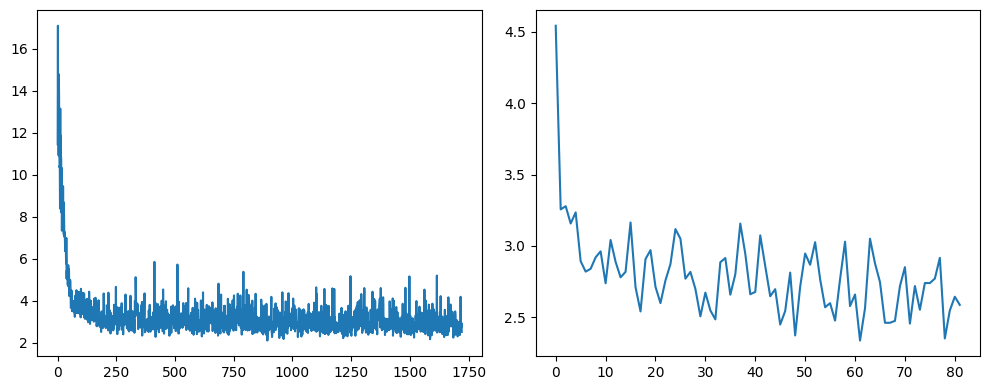

In [17]:
# definizione datasets e dataloaders
# vengono istanziati ogni volta che la run ha inizio così da gestire meglio ed impedire
# errori sul calcolo dei batch
train_dataset = CustomDataset(train_df, BATCH_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_dataset = CustomDataset(val_df, BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

t_loss_list, v_loss_list = [], []
loop = tqdm(range(run.config['epochs']), unit="epoch")
early_stopping = EarlyStopper(patience=20)
best_vloss = 1_000_000.
loss = nn.L1Loss()

run.config['early_stopping'] = str(early_stopping)
run.config['save_best'] = True
run.watch(model)

for epoch in loop:
    model.train()
    for batch_idx, (before, target, future, after, m_b, b_t, m_a, timestamps) in enumerate(train_dataloader):        
        target, before, after, future = target.to(device), before.to(device), after.to(device), future.to(device)
        
        train_pred = model(before, after, future)
        
        train_loss = loss(train_pred, target)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        t_loss_list.append(train_loss.item())
    
    model.eval()
    running_vloss = 0.0
    
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (vbefore, vtarget, vfuture, vafter, vm_b, vm_t, vm_a, vtimestamp) in enumerate(val_dataloader):
            vbefore, vtarget, vfuture, vafter = vbefore.to(device), vtarget.to(device), vfuture.to(device), vafter.to(device)
            voutputs = model(vbefore, vafter, vfuture)
            vloss = loss(voutputs, vtarget)
            running_vloss += vloss

    # resetting dataset generation
    # TODO: fix con DROP LAST
    train_dataset.reset()
    val_dataset.reset()
    
    avg_vloss = running_vloss / (i + 1) # TODO: ricontrollare
    v_loss_list.append(avg_vloss.item())
    
    loop.set_description(f"Epoch [{epoch}/{run.config['epochs']}]")
    loop.set_postfix(loss=t_loss_list[-1], val_loss=v_loss_list[-1])
    
    run.log({"loss": t_loss_list[-1], "val_loss": v_loss_list[-1]})
    
    print(
            f"Epoch {epoch+1:02d}/{run.config['epochs']:02d}"
            f" | Train Loss {t_loss_list[-1]:.3f}"
            f" | Val Loss {v_loss_list[-1]:.3f}"
        )
    
    # save model when improves loss
    if avg_vloss < best_vloss:
        print(f"\tSaving model (improve loss) {best_vloss} -> {avg_vloss}")
        best_vloss = avg_vloss
        model_path = f"GRRUN_b{run.config['batch_size']}_e{run.config['epochs']}.model"
        torch.save(model.state_dict(), model_path)

    # check for early stopping
    if early_stopping.early_stop(v_loss_list[-1]):
        print(f"\tEarly Stopping @ epoch {epoch} loss: {t_loss_list[-1]} val_loss: {v_loss_list[-1]}")
        break

# plot training/validation loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(t_loss_list)
axes[1].plot(v_loss_list)
fig.tight_layout()

## Evaluation

In [14]:
import plotly.express as px
from torchmetrics.regression import MeanAbsolutePercentageError

In [18]:
model.load_state_dict(torch.load('GRUN_b10_e100.model')) # TODO: rendere parametrico il path
model.eval()

NeuralNetwork(
  (input_before): GRU(47, 32, batch_first=True)
  (input_after): GRU(47, 32, batch_first=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1_2): Linear(in_features=64, out_features=128, bias=True)
  (linear2_2): Linear(in_features=128, out_features=128, bias=True)
  (loopGru): GRU(17, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)

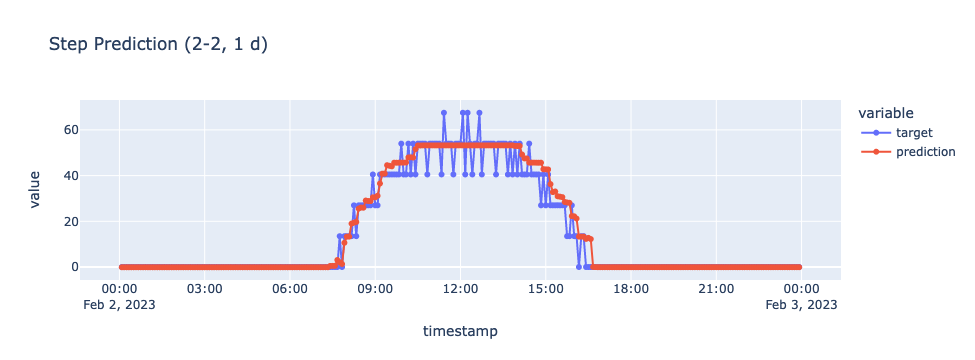

MAPE (2-2): 0.7090684771537781


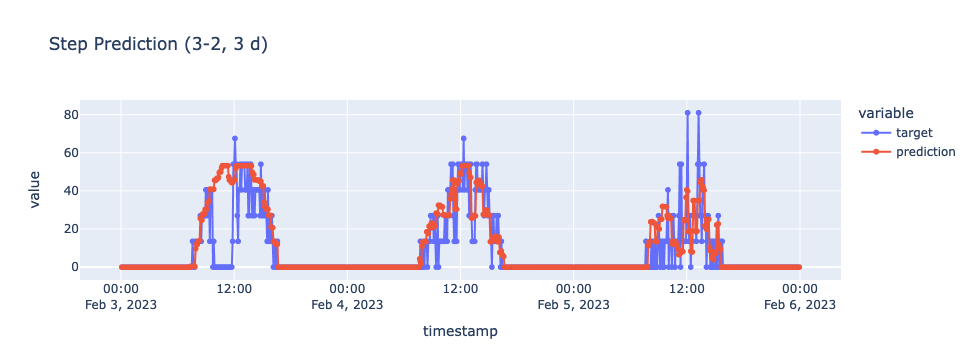

MAPE (3-2): 1.352821707725525


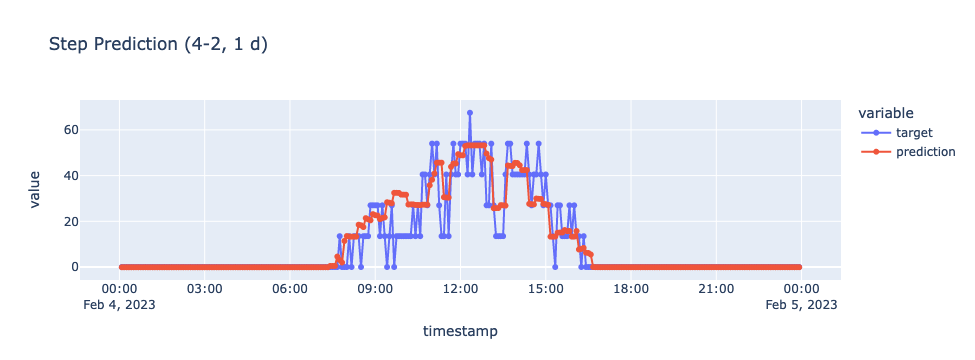

MAPE (4-2): 0.7811287641525269


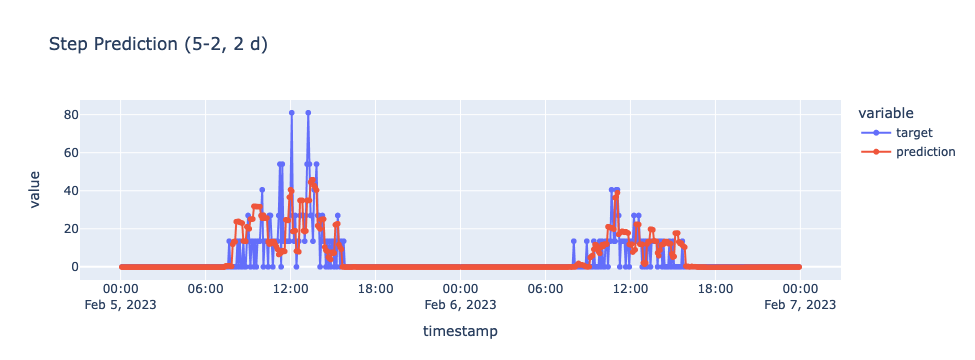

MAPE (5-2): 3.178332805633545


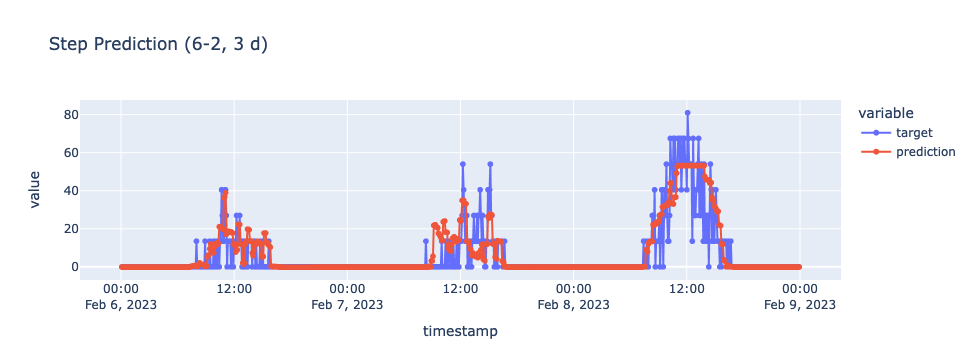

MAPE (6-2): 2.4377830028533936


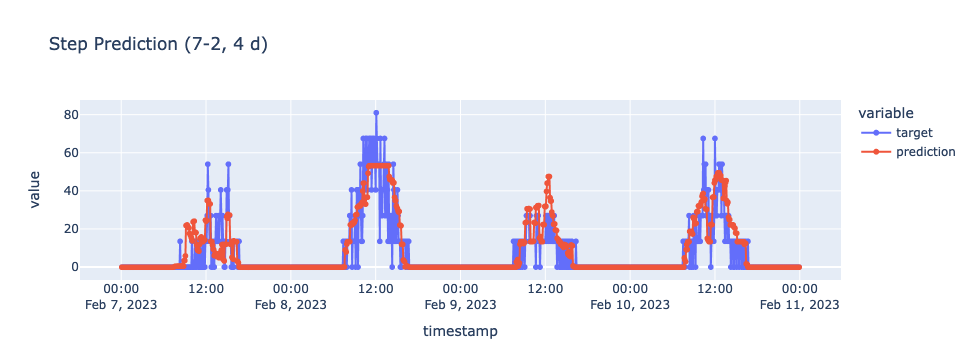

MAPE (7-2): 2.7001471519470215


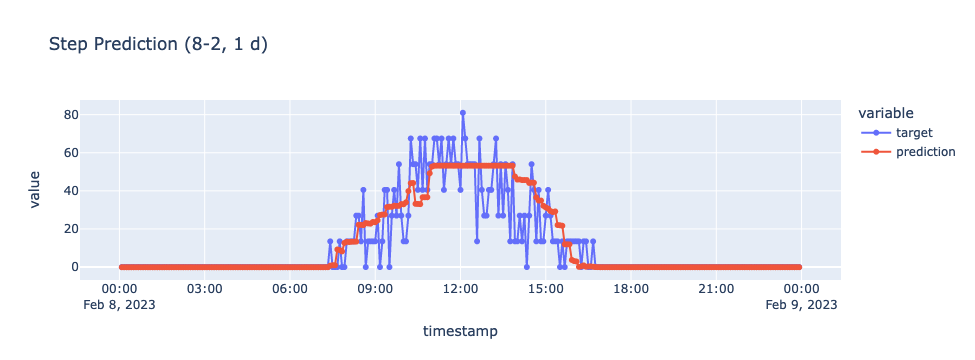

MAPE (8-2): 1.899426817893982


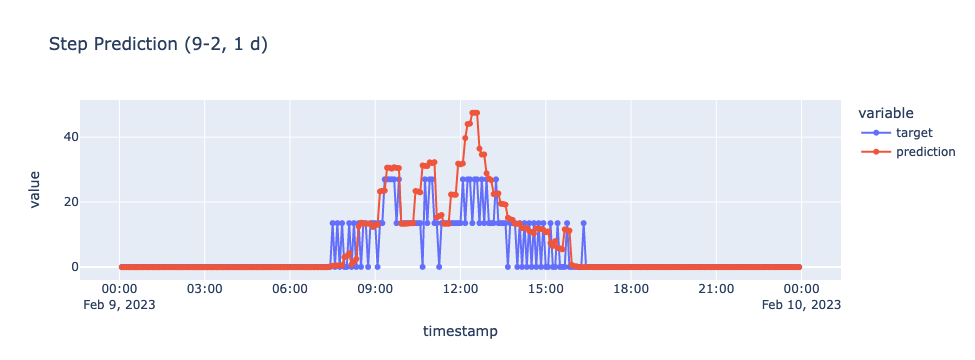

MAPE (9-2): 1.8817576169967651


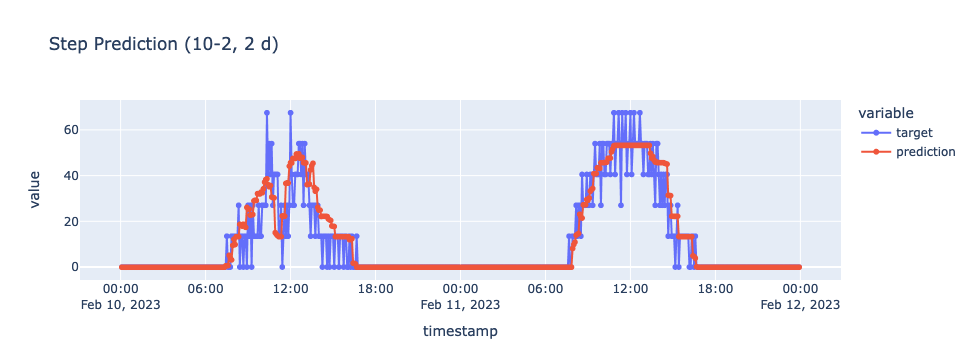

MAPE (10-2): 1.4600257873535156


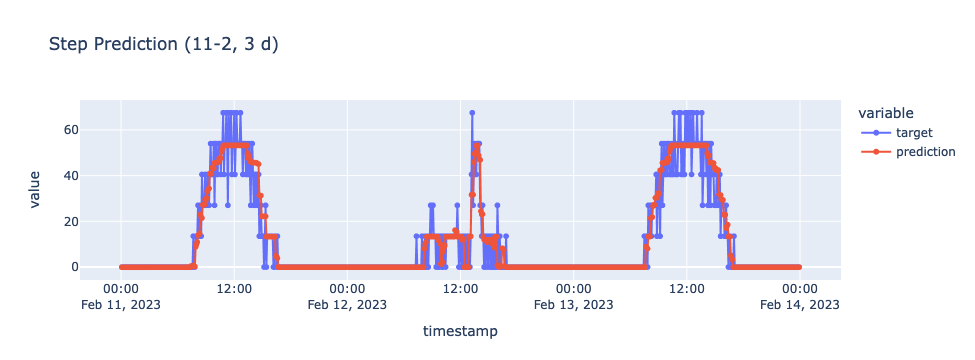

MAPE (11-2): 4.7562665939331055


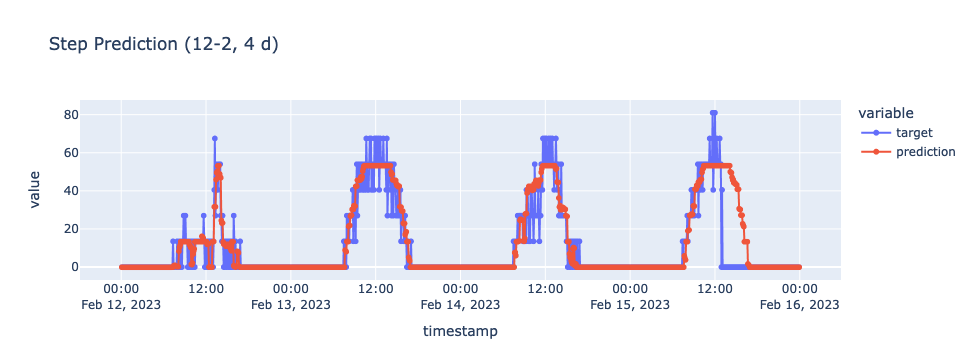

MAPE (12-2): 8.155200958251953


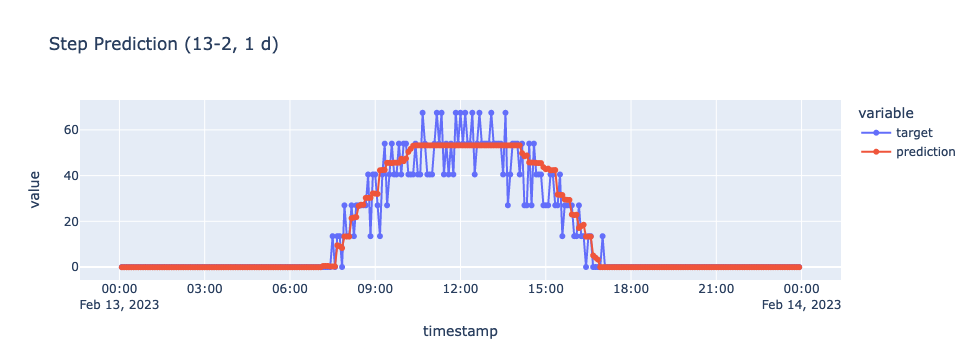

MAPE (13-2): 1.4937793016433716


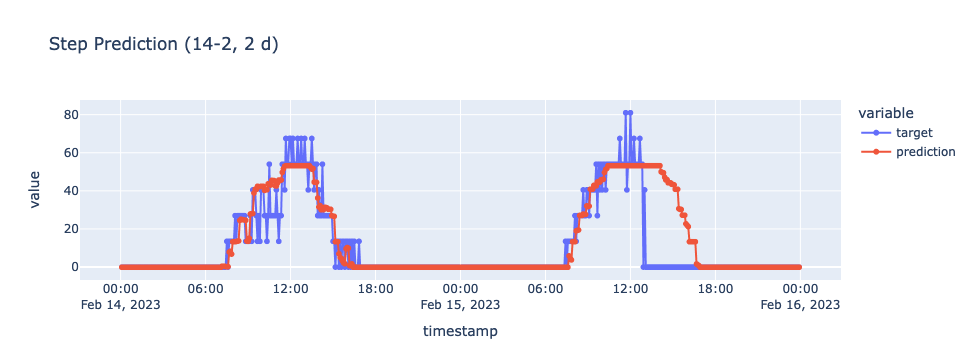

MAPE (14-2): 9.542412757873535


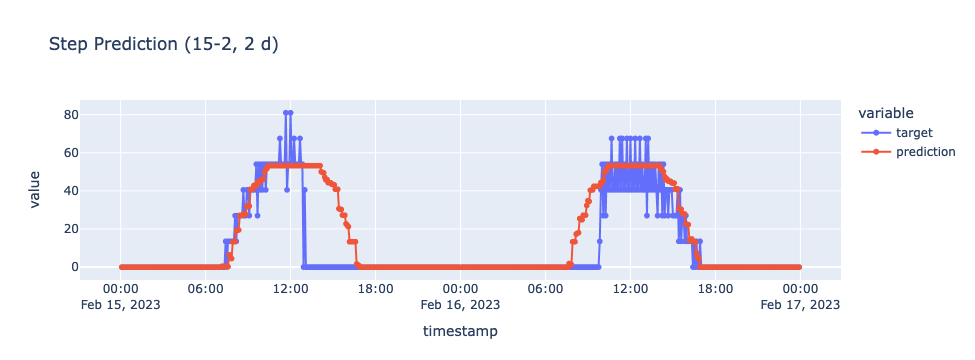

MAPE (15-2): 1.3184340000152588


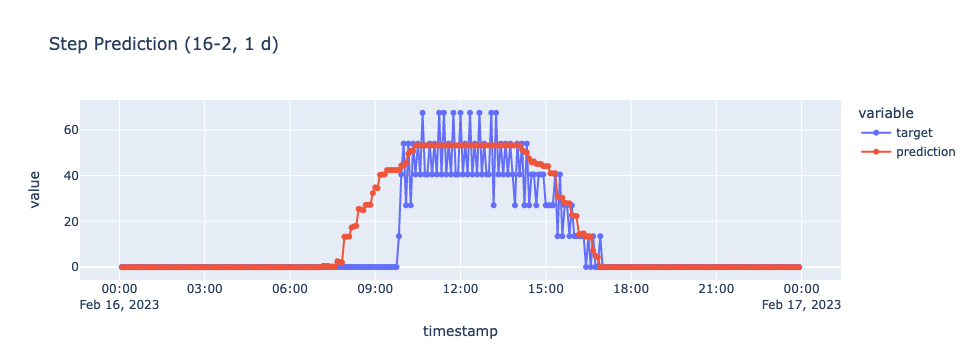

MAPE (16-2): 1.393330693244934


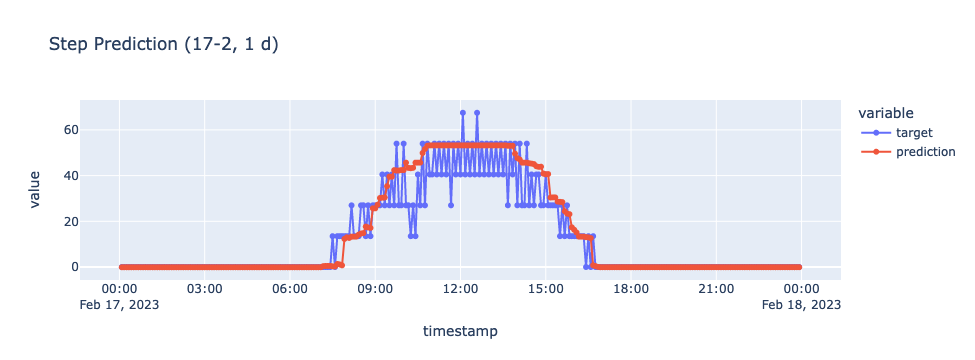

MAPE (17-2): 1.0411882400512695


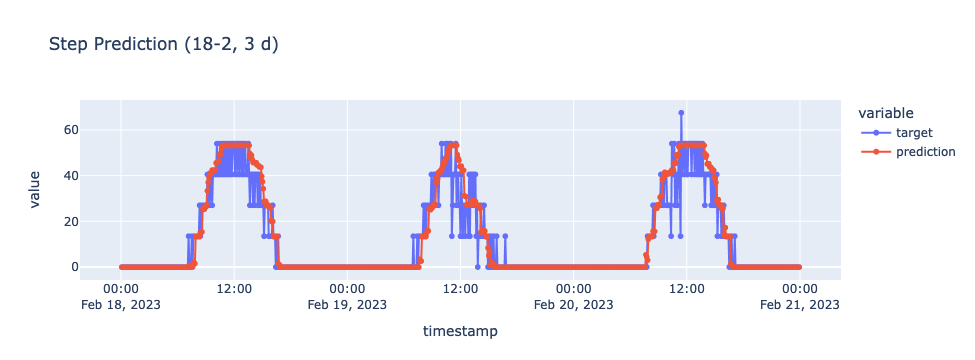

MAPE (18-2): 2.176676034927368


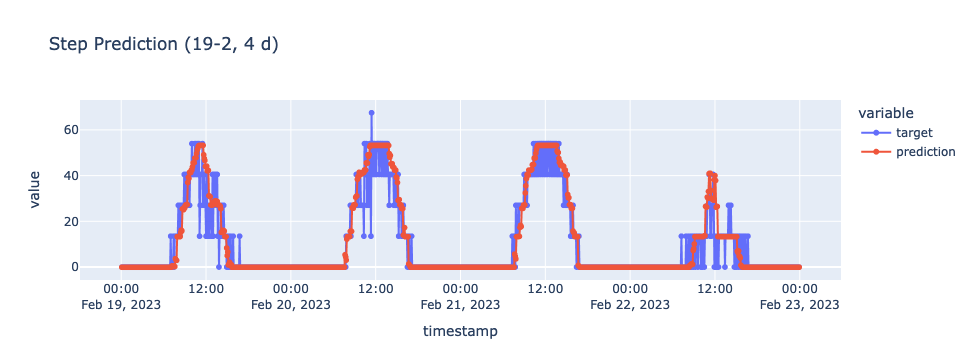

MAPE (19-2): 3.2810769081115723


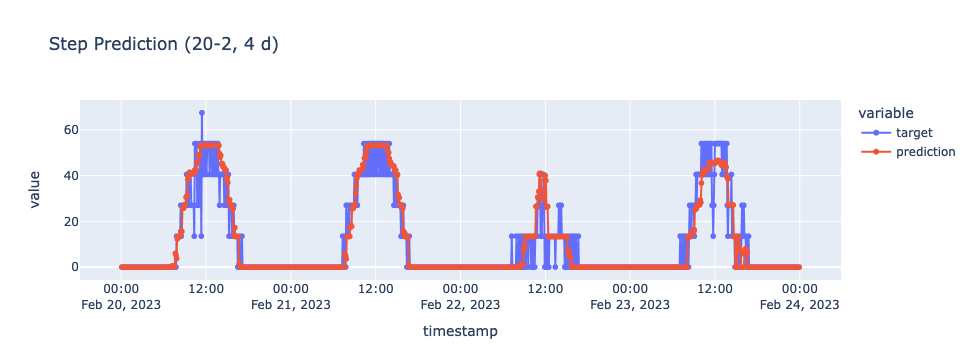

MAPE (20-2): 56.86785888671875


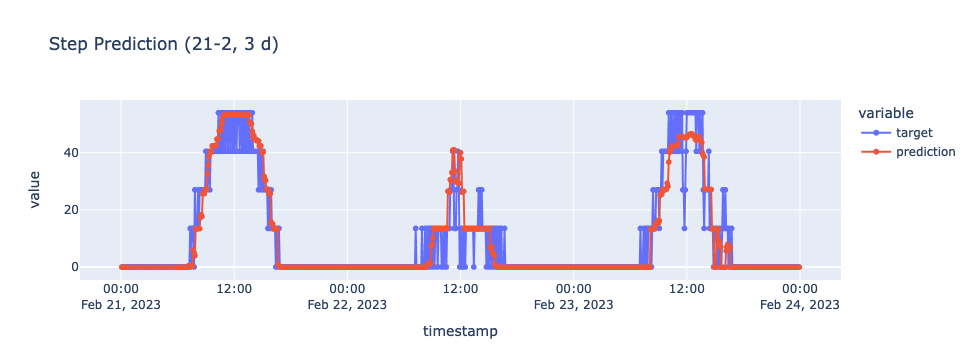

MAPE (21-2): 74.80047607421875


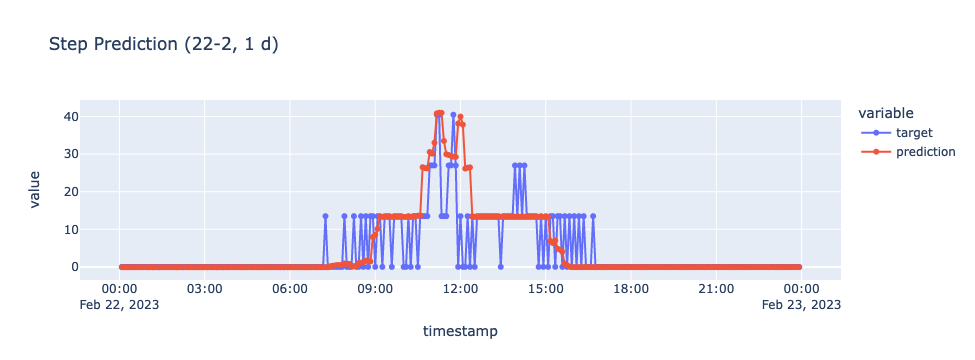

MAPE (22-2): 4.589795112609863


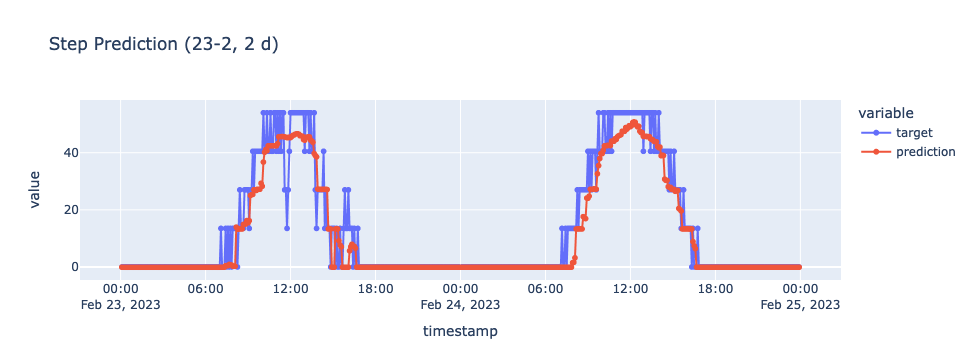

MAPE (23-2): 7.843992233276367
Mape Global:  9.221951425075531


In [23]:
test_dataset = CustomDataset(test_df, 1)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=collate_fn,
    shuffle=False
)

result = pd.DataFrame()
mean_abs_percentage_error = MeanAbsolutePercentageError()
mape_points = []
mape = 0

# Create a table
table = wandb.Table(columns = ["Evaluation (on Testing Set)", "MAPE"])

# Create path for Plotly figure
path_to_plotly_html = "./plotly_figure.html"

for i, (vbefore, vtarget, vfuture, vafter, vm_b, vm_t, vm_a, timestamps) in enumerate(test_dataloader):
    timestamp =  pd.to_datetime(pd.Series(timestamps[0]))
    timestamp = timestamp[vm_t[0] == 1]
        
    vbefore, vafter, vfuture = vbefore.to(device), vafter.to(device), vfuture.to(device)
    prediction = model(vbefore, vafter, vfuture)
    
    # TODO: ricontrollare mape
    step_mape = mean_abs_percentage_error(vtarget, prediction.cpu().detach()).item()
    mape_points.append(step_mape)
    mape += step_mape
    
    vtarget = pd.DataFrame(vtarget.numpy().reshape(vtarget.shape[1], 1)) # TODO: rendere parametrico
    vtarget.columns = ['target']
    
    prediction = pd.DataFrame(prediction.cpu().detach().numpy().reshape(prediction.shape[1],1)) # TODO: rendere parametrico
    prediction.columns = ['prediction']
    
    step_result = pd.concat([vtarget, prediction], axis=1)
    step_result.index = timestamp

    fig = px.line(step_result, y=['target', 'prediction'], title=f"Step Prediction ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}, {int(np.count_nonzero(vm_t[0]==1)/287)} d)", markers=True)
    fig.write_html(path_to_plotly_html, auto_play=False) 
    fig.show()
    
    table.add_data(wandb.Html(path_to_plotly_html), step_mape)

    result =  pd.concat([result, step_result])
    
    print(f"MAPE ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}): {step_mape}")

print("Mape Global: ", mape/i) # TODO: ricontrollare

# Log Table
run.log({"evluation_table": table})
run.finish()

## TODO

IN FASE DI TRAINING

prendo curva predetta / sua area * area reale